# Практическое задание по занятию Denosing Diffusional Models

ФИО:

## Задание

0) Скачайте репозиторий git clone https://github.com/awjuliani/pytorch-diffusion.git

1) Обучите модель для датасета Fasion MNIST. Продемонстрируйте обратный диффузионный процесс с нескольких random seeds (1 балл)

2) Добавьте к обучению DDPM условие на метку с помощью Classifier Free Guidance https://arxiv.org/abs/2207.12598. (2 балла)

3) Обучите модель в режиме inpainting. Параграф 4.1 в https://arxiv.org/pdf/2201.09865.pdf . (1 балл)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from data import DiffSet
from model import DiffusionModel


/home/ubuntu/myapp/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
import numpy as np
import torchvision

In [4]:
batch_size = 128
num_workers = 4  
dataset_name = "Fashion"

train_dataset = DiffSet(train=True, dataset=dataset_name)
val_dataset = DiffSet(train=False, dataset=dataset_name)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)


In [7]:
def show_batch(loader, n=8):
    batch = next(iter(loader))
    batch = batch[:n]
    grid = torchvision.utils.make_grid(batch, nrow=4, normalize=True, padding=2)
    np_grid = grid.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np_grid, cmap='gray')
    plt.axis('off')
    plt.show()

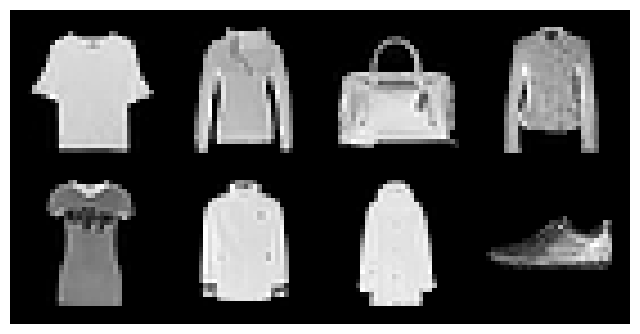

In [11]:
show_batch(train_loader)

In [12]:
in_size = 32  
t_range = 1000  
img_depth = 1  

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = DiffusionModel(in_size=in_size, t_range=t_range, img_depth=img_depth)
device

'cuda'

In [13]:
print(model)


DiffusionModel(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(1, 64, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): GroupNorm(1, 64, eps=1e-05, affine=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GroupNorm(1, 64, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): GroupNorm(1, 64, eps=1e-05, affine=True)
        )
      )
      (2): DoubleConv(
        (double_conv): Sequential

In [15]:
checkpoint_callback = ModelCheckpoint(
    monitor='val/loss',
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min',
)

early_stop_callback = EarlyStopping(
    monitor='val/loss',
    patience=10,
    verbose=True,
    mode='min'
)

trainer = pl.Trainer(max_epochs=20,accelerator="auto")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/myapp/env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [16]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name  | Type       | Params | Mode 
----------------------------------------------
0  | inc   | DoubleConv | 37.7 K | train
1  | down1 | Down       | 295 K  | train
2  | down2 | Down       | 1.2 M  | train
3  | down3 | Down       | 2.4 M  | train
4  | up1   | Up         | 6.2 M  | train
5  | up2   | Up         | 1.5 M  | train
6  | up3   | Up         | 406 K  | train
7  | outc  | OutConv    | 65     | train
8  | sa1   | SAWrapper  | 395 K  | train
9  | sa2   | SAWrapper  | 395 K  | train
10 | sa3   | SAWrapper  | 99.6 K | train
----------------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.676    Total estimated model params size (MB)
141       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|███████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.21it/s, v_num=0]
idation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|███████████████████████████████████████████████████████████████| 469/469 [01:02<00:00,  7.51it/s, v_num=0]
idation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|███████████████████████████████████████████████████████████████| 469/469 [01:02<00:00,  7.52it/s, v_num=0]
idation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|███████████████████████████████████████████████████████████████| 469/469 [01:02<00:00,  7.51it/s, v_num=0]
idation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████████████████████████

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████| 469/469 [01:10<00:00,  6.67it/s, v_num=0]


In [17]:
trainer.save_checkpoint("final_model.ckpt")

In [26]:
def sample(model, diffusion, n_samples=16, device='cuda'):
    model.eval()
    with torch.no_grad():
        x = torch.randn(n_samples, 1, model.in_size, model.in_size, device=device)

        for t in reversed(range(diffusion.t_range)):
            t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
            x = diffusion.denoise_sample(x, t_batch)
        
        x = torch.clamp(x, -1.0, 1.0)
        
        return x


In [27]:
def show_generated(images, nrow=4):
    grid = torchvision.utils.make_grid(images, nrow=nrow, normalize=True, padding=2)
    np_grid = grid.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np_grid, cmap='gray')
    plt.axis('off')
    plt.show()

In [28]:
n_samples = 16
generated_images = sample(model, model, n_samples=n_samples, device=device)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
show_generated(generated_images)

### Classifier-Free Guidance

In [29]:
import torch
from torch.utils.data import Dataset
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torchvision import transforms


In [30]:
class DiffSet(Dataset):
    def __init__(self, train, dataset="MNIST"):
        transform = transforms.Compose([transforms.ToTensor()])

        datasets = {
            "MNIST": MNIST,
            "Fashion": FashionMNIST,
            "CIFAR": CIFAR10,
        }

        train_dataset = datasets[dataset](
            "./data", download=True, train=train, transform=transform
        )

        self.dataset_len = len(train_dataset.data)
        self.dataset = train_dataset
        self.dataset_name = dataset

        if dataset == "MNIST" or dataset == "Fashion":
            pad = transforms.Pad(2)
            data = pad(train_dataset.data)
            data = data.unsqueeze(3)
            self.depth = 1
            self.size = 32
        elif dataset == "CIFAR":
            data = torch.Tensor(train_dataset.data)
            self.depth = 3
            self.size = 32
        self.input_seq = ((data / 255.0) * 2.0) - 1.0
        self.input_seq = self.input_seq.moveaxis(3, 1)

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, item):
        if self.dataset_name in ["MNIST", "Fashion"]:
            img = self.input_seq[item]
            label = self.dataset.targets[item]
            return img, label
        elif self.dataset_name == "CIFAR":
            img = self.input_seq[item]
            label = self.dataset.targets[item]
            return img, label

In [31]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import math
from modules import *

In [32]:
class DiffusionModel(pl.LightningModule):
    def __init__(self, in_size, t_range, img_depth, num_classes=10, p_uncond=0.1):
        super().__init__()
        self.beta_small = 1e-4
        self.beta_large = 0.02
        self.t_range = t_range
        self.in_size = in_size
        self.img_depth = img_depth
        self.num_classes = num_classes
        self.p_uncond = p_uncond  # Вероятность игнорирования условия

        # Создание расписания β
        self.beta = torch.linspace(self.beta_small, self.beta_large, self.t_range)
        self.alpha = 1.0 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.0], device=self.beta.device), self.alpha_cumprod[:-1]], dim=0)

        # Регистрация буферов
        self.register_buffer('beta_tensor', self.beta)
        self.register_buffer('alpha_tensor', self.alpha)
        self.register_buffer('alpha_cumprod_tensor', self.alpha_cumprod)
        self.register_buffer('alpha_cumprod_prev_tensor', self.alpha_cumprod_prev)

        # Эмбеддинг классов
        self.class_embedding = nn.Embedding(num_classes + 1, 128)  # +1 для unconditional

        # Архитектура модели
        bilinear = True
        self.inc = DoubleConv(img_depth + 128, 64)  # Добавляем размер эмбеддинга
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, img_depth)
        self.sa1 = SAWrapper(256, 8)
        self.sa2 = SAWrapper(256, 4)
        self.sa3 = SAWrapper(128, 8)

    def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

    def forward(self, x, t, c):
        """
        Model is U-Net with added positional encodings and self-attention layers.
        c: метки классов [batch_size]
        """
        # Генерация эмбеддинга классов
        # Если c == num_classes, то это unconditional
        c_embed = self.class_embedding(c)
        c_embed = c_embed.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, self.in_size, self.in_size)

        # Конкатенация эмбеддинга к входу
        x = torch.cat([x, c_embed], dim=1)  # Увеличиваем количество каналов

        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, 256, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, 4)
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, 64, 32)
        output = self.outc(x)
        return output

    def get_loss(self, batch, batch_idx):
        """
        Соответствует Алгоритму 1 из (Ho et al., 2020).
        """
        imgs, labels = batch  # Получаем изображения и метки классов

        # Случайным образом решаем, использовать ли условие или нет
        uncond_mask = torch.rand(labels.shape, device=self.device) < self.p_uncond
        c = labels.clone()
        c[uncond_mask] = self.num_classes  # Индекс для unconditional

        ts = torch.randint(0, self.t_range, [imgs.shape[0]], device=self.device)
        a_hat = self.alpha_cumprod_tensor[ts].view(-1, 1, 1, 1)
        epsilons = torch.randn_like(imgs)
        noise_imgs = torch.sqrt(a_hat) * imgs + torch.sqrt(1 - a_hat) * epsilons
        e_hat = self.forward(noise_imgs, ts.float(), c)
        loss = nn.functional.mse_loss(e_hat, epsilons)
        return loss

    def denoise_sample(self, x, t, c):
        """
        Соответствует внутреннему циклу Алгоритма 2 из (Ho et al., 2020).
        """
        with torch.no_grad():
            a_hat = self.alpha_cumprod_tensor[t].view(-1, 1, 1, 1)
            a_hat_prev = self.alpha_cumprod_prev_tensor[t].view(-1, 1, 1, 1)
            beta_t = self.beta_tensor[t].view(-1, 1, 1, 1)
            eps_hat = self.forward(x, t.float(), c)

            mu = (x - torch.sqrt(1 - a_hat) * eps_hat) / torch.sqrt(a_hat)
            if t > 0:
                noise = torch.randn_like(x)
                sigma = torch.sqrt(beta_t)
                x = mu + sigma * noise
            else:
                x = mu
            return x

    def training_step(self, batch, batch_idx):
        loss = self.get_loss(batch, batch_idx)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.get_loss(batch, batch_idx)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        return optimizer

In [33]:
batch_size = 128
num_workers = 4  
dataset_name = "Fashion"  


train_dataset = DiffSet(train=True, dataset=dataset_name)
val_dataset = DiffSet(train=False, dataset=dataset_name)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)


In [34]:
in_size = 32  # Размер изображения после паддинга
t_range = 1000  # Количество таймстемпов диффузии
img_depth = 1  # Глубина изображения: 1 для grayscale, 3 для RGB
num_classes = 10  # Для FashionMNIST
p_uncond = 0.1  # Вероятность игнорирования условия


model = DiffusionModel(in_size=in_size, t_range=t_range, img_depth=img_depth, num_classes=num_classes, p_uncond=p_uncond)


In [36]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Настройка чекпоинтов для сохранения лучших моделей
checkpoint_callback = ModelCheckpoint(
    monitor='val/loss',
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min',
)

# Настройка ранней остановки (опционально)
early_stop_callback = EarlyStopping(
    monitor='val/loss',
    patience=10,
    verbose=True,
    mode='min'
)

# Инициализация тренера
trainer = pl.Trainer(max_epochs=20,accelerator="auto")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [37]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name            | Type       | Params | Mode 
--------------------------------------------------------
0  | class_embedding | Embedding  | 1.4 K  | train
1  | inc             | DoubleConv | 111 K  | train
2  | down1           | Down       | 295 K  | train
3  | down2           | Down       | 1.2 M  | train
4  | down3           | Down       | 2.4 M  | train
5  | up1             | Up         | 6.2 M  | train
6  | up2             | Up         | 1.5 M  | train
7  | up3             | Up         | 406 K  | train
8  | outc            | OutConv    | 65     | train
9  | sa1             | SAWrapper  | 395 K  | train
10 | sa2             | SAWrapper  | 395 K  | train
11 | sa3             | SAWrapper  | 99.6 K | train
--------------------------------------------------------
13.0 M    Trainable params
0         Non-trainable params
13.0 M    Total params
51.977    Total estimated model params size (MB)
142       Modules in train mode
0         Modules 

Sanity Checking DataLoader 0:   0%|                                                               | 0/2 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (8192) must match the size of tensor b (64) at non-singleton dimension 1

Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: